# 최솟값, 최댓값 그리고 혼합분포(Minimum, Maximum and Mixture)

앞 장에서는 합의 분포(distribution of sums)를 구했었다. 

이 장에서는 최솟값과 최댓값의 분포(distributions of minimums and maximums)를 구하고, 이를 사용해서 일반 연산 및 역산 문제를 풀어본다. 그리고 다른 분포간의 혼합분포를 살펴보겠다.

혼합분포(mixtures of other distribution)는 예측에 있어 유용하다. 

하지만 일단 분포를 다루는 강력한 도구인 누적분포함수(CDF; Cumulative Distribution Function)에 대해 알아보자. 

## 7.1 누적분포함수

앞서 분포를 나타내는 데 확률질량함수를 사용했다. 대신 사용할 수 있는 유용한 도구로 누적분포함수가 있다. 

한 가지 예로, 4.3절의 베이지안 추정에서 다루었던 유로 문제의 사후확률분포를 살펴보자. 우선 균등사전분포에서 시작한다.

In [1]:
import numpy as np
from empiricaldist import Pmf

# 가능한 101개의 가설. 동전은 0의 확률로 앞면이 나올 수 있다 ~ 동전은 1의 확률로 앞면이 나올 수 있다.
hypos = np.linspace(0,1, 101)

pmf = Pmf(1, hypos)
pmf.normalize() # 앞서 말했듯이, 균등사전분포일 경우 사전확률이 1이든 0.xx 이든 차이가 발생하지 않는다. 다만, 본인이 그냥 1인 사전확률분포를 안 좋아하므로 normalize()를 시행한다.

print(pmf)

data = 140, 250 # 앞면이 140회, 뒷면은 110회 도합 250회  data = (140, 250)
print(data)

0.00    0.009901
0.01    0.009901
0.02    0.009901
0.03    0.009901
0.04    0.009901
          ...   
0.96    0.009901
0.97    0.009901
0.98    0.009901
0.99    0.009901
1.00    0.009901
Length: 101, dtype: float64
(140, 250)


갱신된 내용은 다음과 같다.

In [2]:
from utils import make_binomial
from scipy.stats import binom

In [3]:
def update_binomial(pmf:Pmf, data: list or tuple)->None:
    """이항분포를 사용한 pmf 갱신"""
    k,n = data
    xs = pmf.qs
    likelihood = binom.pmf(k,n,xs) # binom(k,n,p)
    pmf *= likelihood
    pmf.normalize()

In [4]:
update_binomial(pmf, data)

"""
pmf = np.linspace(0,1,101)
data = 140,250
update_binomial(pmf, data)
->
k, n = 140, 250
xs = 0.01 ~ 1.00
likelihood = binom.pmf(140, 250, [0.01~ 1.00])
pmf *= likelihood
pmf.normalize()
"""

'\npmf = np.linspace(0,1,101)\ndata = 140,250\nupdate_binomial(pmf, data)\n->\nk, n = 140, 250\nxs = 0.01 ~ 1.00\nlikelihood = binom.pmf(140, 250, [0.01~ 1.00])\npmf *= likelihood\npmf.normalize()\n'

cdf 는 pmf의 누적합이므로, 0~1 사이의 값을 지닌다. 

__pmf == pdf, pmf = Probability mass function, pdf = probability density function__

In [5]:
cumulative = pmf.cumsum() 

In [6]:
cumulative

0.00     0.000000e+00
0.01    1.256330e-207
0.02    5.731921e-166
0.03    8.338711e-142
0.04    8.269265e-125
            ...      
0.96     1.000000e+00
0.97     1.000000e+00
0.98     1.000000e+00
0.99     1.000000e+00
1.00     1.000000e+00
Length: 101, dtype: float64

In [7]:
cumulative[0.61] 

0.9638303193984255

결과는 0.96으로 이는 0.61과 같거나 이보다 작은 값에 대한 총 확률이 96%라는 뜻이다. 

다른 방식으로 살펴보자. 확률과 이에 대응하는 값을 연결시켜 찾아보는 방식으로 보기 위해, 보간법(interpolation)을 이용하자.

In [8]:
from scipy.interpolate import interp1d

ps = cumulative.values
qs = cumulative.index

interp = interp1d(ps,qs)
interp(0.96)

array(0.60890171)

결과는 약 0.61이므로 이 분포의 96분위에 해당하는 값이 0.61임을 알 수 있다.

empiricaldist에서는 누적분포함수를 나타내는 클래스인 CDF를 사용할 수 있다. Pmf를 가지고 다음과 같이 CDF를 구할 수 있다.

In [9]:
cdf = pmf.make_cdf()
cdf

,probs
0.00,0.000000e+00
0.01,1.256330e-207
0.02,5.731921e-166
0.03,8.338711e-142
0.04,8.269265e-125
...,...
0.96,1.000000e+00
0.97,1.000000e+00
0.98,1.000000e+00
0.99,1.000000e+00


make_cdf()는 np.cumsum()을 사용해서 확률의 누적합을 구한다. 그래서 Cdf에서 원소를 선택할 때 대괄호를 사용한다.

cdf 객체가 유용한 한 가지 이유는 이 객체에서 백분위를 효율적으로 구할 수 있기 때문이다.

또 다른 이유는 이 객체에서는 분포의 최댓값이나 최솟값을 쉽게 구할 수 있기 때문이다. 여기에 대해서는 다음 절에서 좀 더 자세히 살펴보겠다.

## 7.2 넷 중 높은 값

- 던전앤드래곤에서 각 캐릭터는 근력,지능,지혜,민첩,건강,매력의 6가지 능력치를 가진다. 
- 새로운 캐릭터를 만들 때는 플레이어는 각 능력치에 대해 육면체 주사위 4개를 굴린 후 이 중 세 개의 높은 값을 더한다.
- 예를 들어 내가 근력치를 얻고자 주사위를 4개를 굴려서 1,2,3,4가 나왔다면 내 캐릭터의 근력은 제일 낮은 값 1을 제외하고 나머지를 더한 값, 9가 된다. 
- 연습 삼아 이 능력치의 분포를 구해보자. 그리고 각 캐릭터에 대해 그들의 가장 높은 능력치에 대한 분포도 구해보자.
- 앞 장에서 두 개의 함수를 불러오자. 주사위를 굴린 결과에 대한 Pmf를 만드는 make_die()와 Pmf의 수열을 가지고 이 합의 분포를 구하는 add_dist_seq()다. 
- 다음은 육면체 주사위를 나타내는 Pmf와 이 객체 세 개를 사용한 수열이다.

In [10]:
from empiricaldist import Pmf
import numpy as np

def make_die(sides:int)->Pmf:
    outcomes = np.arange(1,sides+1)
    die = Pmf(1/sides,outcomes)
    return die

def add_dist_seq(seq):
    """seq = 여러 개의 dist를 가지는 리스트 구조"""
    total = seq[0]
    for other in seq[1:]:
        total = total.add_dist(other)
    return total

import matplotlib.pyplot as plt
import seaborn as sns

def plotting(target, x_label='Number', y_label='PMF')->None:
    # 그림의 가로 세로 비율 조절
    plt.figure(figsize=(10, 5))

    # Seaborn 스타일 설정
    sns.set(style="whitegrid")
    target.plot()

    # title, x label, y label 추가
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # 그래프 표시
    plt.show()

In [11]:
d6 = make_die(6)
dice = [d6] * 3 

pmf_3d6 = add_dist_seq(dice)

print(pmf_3d6)

3     0.004630
4     0.013889
5     0.027778
6     0.046296
7     0.069444
8     0.097222
9     0.115741
10    0.125000
11    0.125000
12    0.115741
13    0.097222
14    0.069444
15    0.046296
16    0.027778
17    0.013889
18    0.004630
dtype: float64


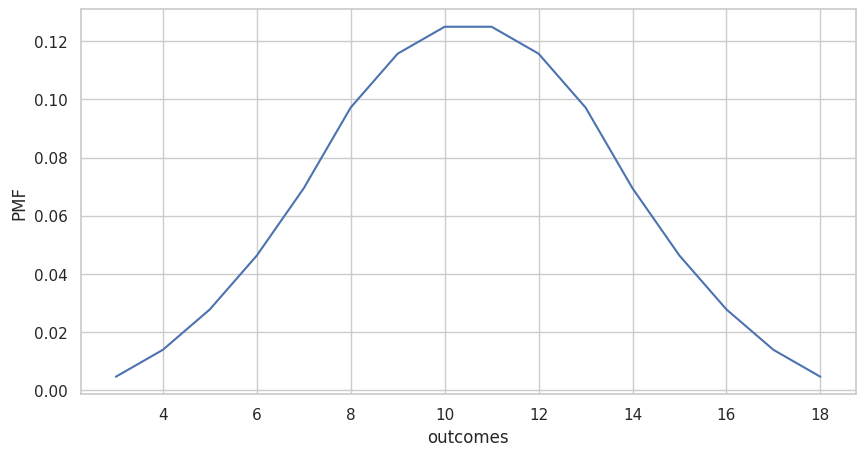

In [12]:
plotting(pmf_3d6, 'outcomes', 'PMF')

In [13]:
cdf_3d6 = pmf_3d6.make_cdf()

만약 주사위 4개를 굴려서 이 중 높은 값 세 개를 더한다면, 이 합의 분포를 구하는 것은 좀 더 까다롭다. 

나는 10,000 개의 주사위에 대해서 시뮬레이션 한 후 분포를 추정한다.

우선 1부터 6까지 임의로 고른 값에 대해 10,000개의 행과 4개의 열을 가진 배열을 만들자.

In [14]:
n = 10000
a = np.random.randint(1,6,size= (n,4)) # low, high, size

각 행에서 세 개의 높은 값을 찾기 위해, axis = 1 로 설정하여 새로 정렬하자. 이렇게 하면 각 행에서 낮은 값부터 큰 값으로 값이 정렬된다. 

이렇게 하면 행렬의 첫번째 열을 제외한다면 가장 높은 값 세 개만 남게 될 것이다.

In [15]:
a.sort(axis = 1) # numpy 의 메서드
a[:5]

array([[1, 1, 5, 5],
       [1, 3, 4, 4],
       [2, 2, 3, 5],
       [2, 4, 5, 5],
       [1, 3, 4, 5]])

In [16]:
a = a[:,1:]

t = a.sum(axis = 1)
t

array([11, 11, 10, ..., 13,  8,  8])

In [17]:
t.max()

15

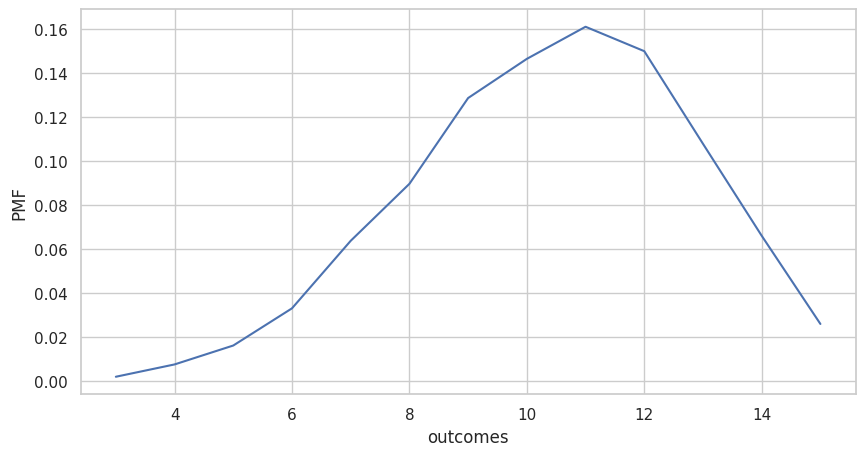

In [18]:
pmf_best3 = Pmf.from_seq(t)
plotting(pmf_best3, 'outcomes', 'PMF')

## 7.3 최댓값

최댓값이나 최솟값의 분포를 알기 위해서는 누적분포함수를 잘 사용해야 한다. 우선 넷 중 높은 값 셋의 CDF를 구해보자.

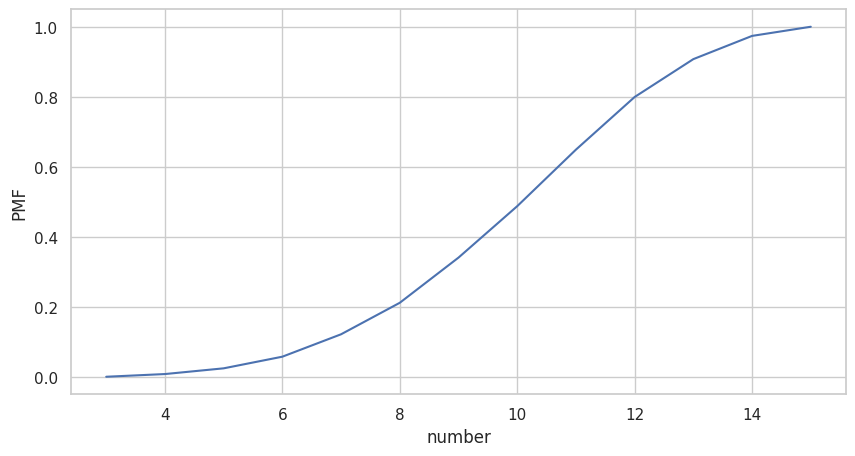

In [19]:
cdf_best3 = pmf_best3.make_cdf()
plotting(cdf_best3, 'number', 'PMF')

cdf(x) 는 x보다 같거나 작은 값에 대한 확률의 합임을 기억하자. 즉 이 분포에서 임의로 고른 값이 x보다 작거나 같을 확률이다. 

이 분포에서 6개의 값을 골랐다고 가정해보자. 모든 6개의 값이 x보다 작거나 같을 확률은 cdf(x)를 6제곱한 값으로, 다음과 같이 구할 수 있다.

### 주석: 왜 모든 6개의 값이 x보다 작거나 같을 확률은 cdf(x)를 6 제곱한 값인가?

- 먼저, cdf(x)는 누적 분포 함수로서, 확률 변수가 특정 값 x 이하일 확률을 나타냅니다. 즉, P(X ≤ x)를 의미합니다.

- 만약 여러 독립적인 확률 변수들이 같은 분포를 따르고 서로 독립이라면, 이들 모두가 특정 값 x 이하일 확률은 각 확률 변수가 x 이하일 확률을 곱한 값과 같습니다. 이를 표현하면 다음과 같습니다.

$[ P(X_1 \leq x, X_2 \leq x, \ldots, X_n \leq x) = P(X_1 \leq x) \times P(X_2 \leq x) \times \ldots \times P(X_n \leq x) ]$

- 만약 확률 변수들이 같은 분포를 따르고 서로 독립이라면, cdf(x)를 이용하여 위의 식을 표현할 수 있습니다.

$[ P(X_1 \leq x, X_2 \leq x, \ldots, X_n \leq x) = [cdf(x)]^n ]$

- 따라서 6개의 독립적인 값이 특정 값 x 이하일 확률은 cdf(x)를 6 제곱한 값과 같습니다. 이는 독립적인 사건의 확률을 곱하는 원리에 기반한 것입니다.

In [20]:
cdf_best3 ** 6

3     8.576612e-17
4     8.858424e-13
5     3.161135e-10
6     4.348387e-08
7     3.496747e-06
8     9.338511e-05
9     1.594529e-03
10    1.357232e-02
11    7.514085e-02
12    2.615547e-01
13    5.593118e-01
14    8.532694e-01
15    1.000000e+00
Name: proportion, dtype: float64

만약 6개의 값이 모두 x보다 작거나 같았다면, 이 떄의 최댓값 역시 x보다 작거나 같다. 따라서 결과는 최댓값에 대한 CDF다. 

우리는 이 결과를 CDF객체를 사용해서 다음과 같이 바꿀 수 있다.

In [21]:
from empiricaldist import Cdf

cdf_max6 = Cdf(cdf_best3**3)
cdf_max6

,probs
3,9.261000e-09
4,9.411920e-07
5,1.777958e-05
6,2.085279e-04
7,1.869959e-03
8,9.663597e-03
9,3.993155e-02
10,1.165003e-01
11,2.741183e-01
12,5.114242e-01


In [22]:
cdf_max_dist6 = cdf_best3.max_dist(6)
cdf_max_dist6

,probs
3,8.576612e-17
4,8.858424e-13
5,3.161135e-10
6,4.348387e-08
7,3.496747e-06
8,9.338511e-05
9,1.594529e-03
10,1.357232e-02
11,7.514085e-02
12,2.615547e-01


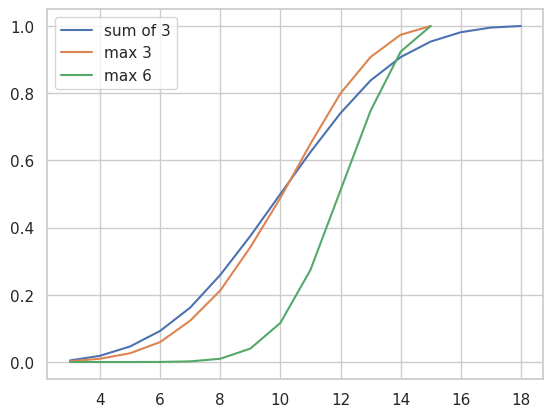

In [23]:
cdf_3d6.plot(label = 'sum of 3')
cdf_best3.plot(label = 'max 3')
cdf_max6.plot(label = 'max 6')

plt.legend()
plt.show()

In [24]:
cdf_max6.make_pmf()

,probs
3,9.261000e-09
4,9.319310e-07
5,1.683839e-05
6,1.907483e-04
7,1.661431e-03
8,7.793638e-03
9,3.026795e-02
10,7.656873e-02
11,1.576180e-01
12,2.373059e-01


## 7.4 최솟값

앞절에서 캐릭터의 최고 능력치의 분포를 구해보았다. 이제 최저 능력치 분포를 알아볼 차례다. 

최솟값의 분포를 구하려면 다음과 같이 구하는 상호보완 CDF를 사용한다.

In [25]:
prob_gt = 1 - cdf_best3 

변수 이름에서 보다시피, 상호보완 CDF는 x보다 큰 분포 상의 값에 대한 확률이다. (gt = greater than) 

모든 6개의 값이 x를 초과할 확률은 다음과 같다. 

In [26]:
prob_gt6 = prob_gt ** 6

만약 6개 속성값 모두가 x를 초과한다면, 최솟값 역시 x를 초과하므로, prob_gt6은 최솟값의 상호보완 CDF가 된다. 

즉 다음과 같이 최솟값의 CDF를 구할 수 있다.

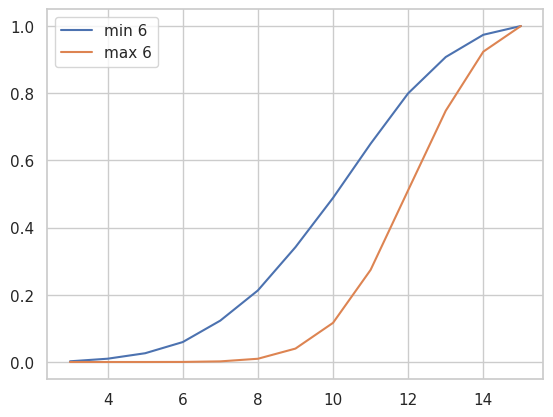

In [27]:
prob_le6 = 1 - prob_gt
cdf_min6 = Cdf(prob_le6)
cdf_min6.plot(label = "min 6")
cdf_max6.plot(label = "max 6")
plt.legend()
plt.show()

CDF 에는 동일한 기능을 하는 min_dist()가 있어서, 다음과 같이 최솟값의 CDF를 구할 수도 있다.

```python
cdf_min_dist6 = cdf_best3.min_dist(6)
```

그리고 이 두 값의 결과 차이가 거의 없다는 것도 확인할 수 있다.

```python
np.allclose(cdf_min_dist6, cdf_min6)
```

이 장의 끝의 연습문제에서, 베이지안 추론에 최댓값과 최솟값의 분포를 사용하게 된다. 

하지만 우선 혼합분포에서 무슨 일이 일어나는지 살펴보자.

## 7.5 혼합

이 장에서는 다른 분포를 혼합한 분포를 구해보자. 이게 무엇인지는 몇 가지 간단한 예를 살펴보며 설명하겠다. 

이를 보다 쓸모있게 사용하기 위해, 이 혼합을 예측에 어떤 식으로 사용하는지를 살펴보자. 다음은 던전앤드래곤에서 가져온 또 다른 예제다.

- 당신의 캐릭터가 한 손에는 대거로, 다른 손에는 숏소드로 무장했다고 가정하자. 
- 각 단계에서, 가지고 있는 두 개의 무기 중 임의로 하나를 골라 괴물을 공격한다. 
- 대거는 사면체 주사위를 한번 굴린 만큼의 피해를 주고, 단검은 육면체 주사위 하나를 굴린 만큼의 피해를 준다.
- 이 때, 각 단계에서 주게 되는 피해의 분포는 어떻게 될까?

In [28]:
# 4면체 주사위 분포
d4 = make_die(4)
# 6면체 주사위 분포
d6

,probs
1,0.166667
2,0.166667
3,0.166667
4,0.166667
5,0.166667
6,0.166667


그럼 이제 1점의 피해를 줄 확률을 구해보자. 

- 대거로 공격한 경우, 1 점의 피해를 줄 확률은 $\frac{1}{4}$ 이다. 
- 숏소드로 공격한 경우 1 점의 피해를 줄 확률은 $\frac{1}{6}$ 이다. 
- 각 무기를 고를 확률은 $\frac{1}{2}$이므로, 총 확률은 둘의 평균이다. 

In [29]:
prob_1 = (d4(1) + d6(1))/2
prob_1

0.20833333333333331

2,3,4 가 나올 확률 역시 이와 동일하지만, 5,6 의 경우에는 다르다. 

사면체 주사위에서는 5,6 의 결과가 나올 수 없기 때문이다. 

이 혼합분포를 구하려면 가능한 결괏값에 대해 반복적으로 계산해서 확률을 구하면 된다. 

하지만 여기서는 동일한 연산을 + 연산자를 사용해서 처리한다.

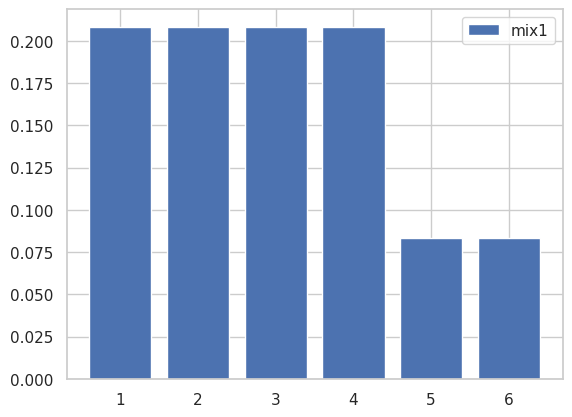

In [30]:
mix1 = (d4 + d6)/2

mix1.bar(label = 'mix1')
plt.legend()
plt.show()

이제 세 마리의 괴물과 전투를 한다고 하자.

- 한 마리는 곤봉을 들고 있고, 이는 d4만큼의 피해를 준다.
- 한 마리는 철퇴를 들고 있고, 이는 d6만큼의 피해를 준다.
- 나머지 한 마리는 육척봉을 들고 있고, 이 경우도 육면체 주사위 하나만큼의 피해를 준다.
- 근접 전투는 무질서하기 때문에, 매 라운드 무작위로 선택되는 몬스터 중 하나의 공격을 받게 된다. 
- 이 몬스터들이 주는 피해의 분포를 찾기 위해, 다음과 같이 이 분포에 대해 가중평균을 구해보자.

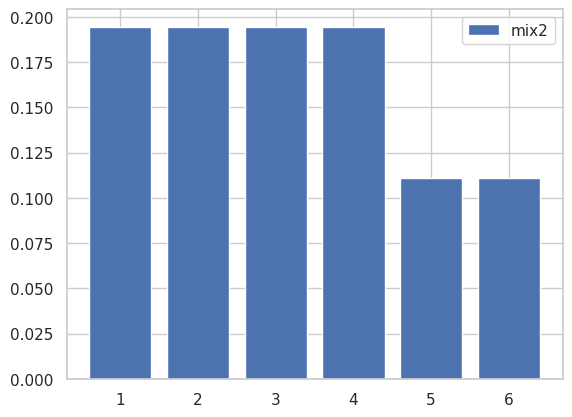

In [31]:
mix2 = (d4 + 2 * d6)/3
mix2.bar(label = 'mix2')
plt.legend()
plt.show()

이 분포는 하나의 사면체 주사위와 두 개의 육면체 주사위의 혼합분포를 나타낸다. 

여기서는 분포의 확률을 더하는 + 연산자를 사용했는데, 이와 분포의 합에 대한 분포를 구하는 Pmf.add_dist() 와 헷갈리지 않도록 하자. 

이 차이에 대해 살펴보기 위해, Pmf.add_dist()를 사용해서 회차별 총 피해의 분포를 구해보도록 하겠다. 

아래는 두 혼합값의 합이다.

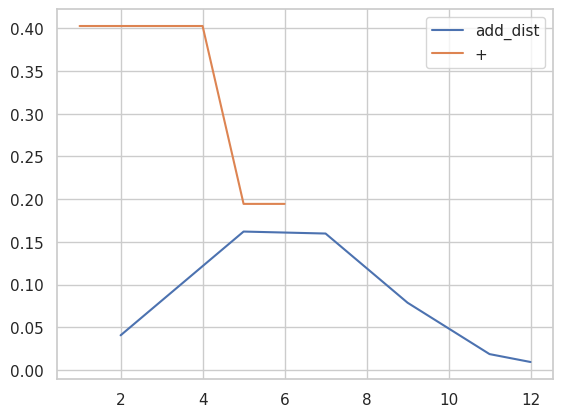

In [32]:
total_damage = Pmf.add_dist(mix1, mix2)
total_damage_2 = mix1 + mix2 
total_damage.plot(label = "add_dist")
total_damage_2.plot(label = "+")

plt.legend()
plt.show()

즉 + 는 가중평균에 대한 분포를 나타내고, add_dist 는 두 개 이상의 분포의 합에 대한 분포를 나타낸다.

## 7.6 일반적인 혼합

앞선 예제에 대해 일반적인 방식을 살펴보자. 

- 세 마리의 괴물이 추가로 전투에 참여했다. 각 괴물은 8면체 주사위를 한번 굴린 결과만큼의 피해를 주는 전쟁도끼를 가지고 있다. 
- 여전히 회당 임의로 선택된 한 마리의 괴물만 공격하므로 이 때 몬스터에 의한 피해는 다음 분포의 혼합이다.
  - 하나의 사면체 주사위(곤봉)
  - 두 개의 육면체 주사위(철퇴, 육척봉)
  - 세 개의 팔면체 주사위(전쟁도끼 * 3)
- 임의로 선택된 괴물을 나타내기 위해 Pmf를 사용하자.

In [33]:
hypos = 4,6,8
counts = 1,2,3
pmf_dice = Pmf(counts, hypos)
pmf_dice

,probs
4,1
6,2
8,3


In [34]:
pmf_dice.normalize()
pmf_dice

,probs
4,0.166667
6,0.333333
8,0.500000


이 분포는 주사위 종류와 각 주사위를 굴릴 확률을 나타낸다. 예를 들어 여섯 괴물 중 한 마리가 대거(d4)를 들고 있으므로, $\frac{1}{6}$ 는 4면체 주사위를 사용한다.

다음은 주사위를 나타내는 Pmf 객체의 sequence data이다. 

In [35]:
dice = [make_die(sides) for sides in hypos]

혼합분포를 구하기 위해 pmf_dice의 확률값을 가중치로 해서 주사위의 가중평균을 구해보도록 하자.

이 계산을 보다 간결하게 나타내려면, 분포를 판다스 데이터프레임에 넣는 것이 편하다. 

In [36]:
import pandas as pd

df = pd.DataFrame(dice)

결과는 각 분포당 한 행이 들어가고, 하나의 가능한 결괏값이 한 열에 들어가는 형태의 데이터프레임으로 나타낸다.

모든 열의 길이가 같지 않으므로 이 경우 판다스는 빈 공간을 숫자가 아닌 특수값을 나타내는 'NaN' 으로 채운다. 이 떄 fillna를 통해 NaN 을 0으로 바꿀 수 있다.

In [37]:
df = df.fillna(0)

In [38]:
df.index = ['d4', 'd6', 'd8']
df = df.transpose()
df

,d4,d6,d8
1,0.25,0.166667,0.125
2,0.25,0.166667,0.125
3,0.25,0.166667,0.125
4,0.25,0.166667,0.125
5,0.00,0.166667,0.125
6,0.00,0.166667,0.125
7,0.00,0.000000,0.125
8,0.00,0.000000,0.125


이제 각 주사위 속 숫자가 뽑힐 확률(likelihood)과 pmf_dice(prior; 각 주사위가 뽑힐 확률)를 곱해보도록 하자. 

In [39]:
pmf_dice.ps

array([0.16666667, 0.33333333, 0.5       ])

In [40]:
0.125 /2 

0.0625

In [41]:
df *= pmf_dice.ps
df

,d4,d6,d8
1,0.041667,0.055556,0.0625
2,0.041667,0.055556,0.0625
3,0.041667,0.055556,0.0625
4,0.041667,0.055556,0.0625
5,0.000000,0.055556,0.0625
6,0.000000,0.055556,0.0625
7,0.000000,0.000000,0.0625
8,0.000000,0.000000,0.0625


그리고 가중분포를 더하자. 

axis = 1 이라는 인수는 행을 기준으로 더한다. (판다스) 결괏값은 판다스 시리즈 형태로 나온다. 

In [42]:
df.sum(axis = 1)

1    0.159722
2    0.159722
3    0.159722
4    0.159722
5    0.118056
6    0.118056
7    0.062500
8    0.062500
dtype: float64

In [43]:
Pmf(df.sum(axis = 1))

,probs
1,0.159722
2,0.159722
3,0.159722
4,0.159722
5,0.118056
6,0.118056
7,0.062500
8,0.062500


다음은 이 과정을 하나로 모은 가중혼합분포를 만드는 함수다. 

이 함수의 처음 인자는 각 가설별(d4,d6,d8) 확률을 나타낸 Pmf다. 두 번째 인자는 각각의 가설에 대한 Pmf 객체의 수열이다. 

In [44]:
def make_mixture(pmf:Pmf, pmf_seq:list or tuple)->Pmf:
    """
    make mixture distribution
    각 주사위가 선택될 사후확률 pmf_dice
    각 주사위가 가능한 확률을 나타내는 Pmf 객체들의 sequence 데이터
    """
    df = pd.DataFrame(pmf_seq).fillna(0).transpose()
    df *= np.array(pmf)
    total = df.sum(axis = 1)
    return Pmf(total)

In [45]:
make_mixture(pmf_dice, dice)

,probs
1,0.159722
2,0.159722
3,0.159722
4,0.159722
5,0.118056
6,0.118056
7,0.062500
8,0.062500


## 7.7 요약

- 이 장에서는 누적분포함수를 나타내는 Cdf 객체를 다루었다. 
- Pmf와 이에 대응하는 Cdf의 경우, 둘이 동일한 정보를 가지고 있다는 점에서 등치하므로, 한 쪽에서 다른 한 쪽으로 빠르게 변환할 수 있다.
- 이 둘의 기본적인 차이는 성능이다. 어떤 연산에서는 Pmf가 빠르고, 어떤 연산에서는 Cdf가 더 빠르다.
- 이 장에서는 Cdf 객체를 사용해서 최댓값과 최솟값의 분포를 구했다. 
- 이 분포들은 데이터로 최댓값이나 최솟값이 주어졌을 때 이를 기반으로 추론하는 경우 유용하게 사용할 수 있다. 
- 또한 혼합값에 대한 분포도 다루었는데, 이를 사용해서 예측을 하는 부분에 대해서는 다음 장에서 다루도록 하자.

## 7.8 연습문제

### 문제 7.1 

- 던전앤드래곤 캐릭터를 만들 때, 주사위를 굴리는 대신 15,14,13,12,10,8 의 능력치를 부여하는 기본 분배값을 사용할 수 있다.
- 기본분배값을 사용하는 것과 주사위를 굴리는 것 중 어느 것이 더 나을 것 같은가?
- 기본 분배값의 분포를 앞서 구했던 주사위 넷 중 좋은 값 세 개에 대한 분포와 비교해보자. 
  - 어떤 분포의 평균이 더 높은가? mean()
  - 어떤 분포의 표준편차가 더 큰가? std()
  - 기본 분배값의 최솟값은 8이다. 각 능력치에서 8보다 더 적은 값이 나올 확률은 얼마인가? 주사위를 6번 굴렸을 때, 최소 하나 이상의 능력치가 8보다 낮을 확률은 얼마인가?
  - 기본 분배값의 최대값은 15이다. 각 능력치에서 15보다 더 큰 값이 나올 확률은 얼마인가? 주사위를 6번 굴렸을 때, 최소 하나 이상의 능력치가 15보다 클 확률은 얼마인가?

In [46]:
pmf_best3 # cdf_best3

,probs
3,0.0021
4,0.0077
5,0.0163
6,0.0332
7,0.0639
8,0.0898
9,0.1288
10,0.1466
11,0.1612
12,0.1501


In [47]:
#  - 어떤 분포의 평균이 더 높은가? mean()
#  - 어떤 분포의 표준편차가 더 큰가? std()

base = [15,14,13,12,10,8]

print(f'base mean: {np.mean(base)}, base standard: {np.std(base)}')

print(f'cdf_best3 mean: {cdf_best3.mean()}, cdf_best3 std: {cdf_best3.std()}')

base mean: 12.0, base standard: 2.3804761428476167
cdf_best3 mean: 10.4054, cdf_best3 std: 2.379674523963309


In [49]:
#   - 기본 분배값의 최솟값은 8이다. 각 능력치에서 8보다 더 적은 값이 나올 확률은 얼마인가? 주사위를 6번 굴렸을 때, 최소 하나 이상의 능력치가 8보다 낮을 확률은 얼마인가?
#   - 기본 분배값의 최대값은 15이다. 각 능력치에서 15보다 더 큰 값이 나올 확률은 얼마인가? 주사위를 6번 굴렸을 때, 최소 하나 이상의 능력치가 15보다 클 확률은 얼마인가?

print(f'각 능력치에서 8보다 더 적은 값이 나올 확률: {cdf_best3.lt_dist(8)}, 주사위를 6번 굴렸을 때, 최소 하나 이상의 능력치가 8보다 낮을 확률: {cdf_min6.lt_dist(8)}')
print(f'각 능력치에서 15보다 더 큰 값이 나올 확률: {cdf_best3.gt_dist(15)}, 주사위를 6번 굴렸을 때, 최소 하나 이상의 능력치가 15보다 클 확률: {cdf_max6.gt_dist(15)}')

각 능력치에서 8보다 더 적은 값이 나올 확률: 0.1232, 주사위를 6번 굴렸을 때, 최소 하나 이상의 능력치가 8보다 낮을 확률: 0.12319999999999998
각 능력치에서 15보다 더 큰 값이 나올 확률: 0.0, 주사위를 6번 굴렸을 때, 최소 하나 이상의 능력치가 15보다 클 확률: 0.0


### 문제 7.2 

- 세 마리의 괴물과 전투를 한다고 가정하자.
  -  한 마리는 d6 의 피해를 주는 대거를 들고 있다.
  -  한 마리는 d8 의 피해를 주는 워엑스를 들고 있다.
  -  한 마리는 d10 만큼의 피해를 주는 바스타드 소드를 들고 있다.
- 세 마리의 괴물 중 임의로 선택된 한 마리가 당신을 공격했고, 1 점의 피해를 얻었다. 이 괴물은 셋 중 어떤 괴물일까? 
- 각 괴물이 공격한 것에 대한 사후확률을 구하여라. 만약 동일한 괴물이 당신을 다시 공격했다면, 이 때 6점의 피해를 입을 확률은 얼마일까? 
- HINT: 이미 구한 사후분포를 사용해서 이를 make_mixture()의 인자 중 하나로 넣자.

In [ ]:
def make_mixture(pmf:Pmf, pmf_seq:list or tuple)->Pmf:
    """
    make mixture distribution
    각 주사위가 선택될 사후확률 pmf_dice
    각 주사위가 가능한 확률을 나타내는 Pmf 객체들의 sequence 데이터
    """
    df = pd.DataFrame(pmf_seq).fillna(0).transpose() # prior 
    df *= np.array(pmf)  # pmf = likelihood
    total = df.sum(axis = 1)
    return Pmf(total)

In [50]:
# 1. 사후분포 구하기(각 괴물이 공격한 것에 대한 사후확률)


hypos = 6,8,10
prior = Pmf(1/3, hypos)
likelihood = 1/prior.qs
posterior = likelihood * prior
posterior.normalize()
posterior

,probs
6,0.425532
8,0.319149
10,0.255319


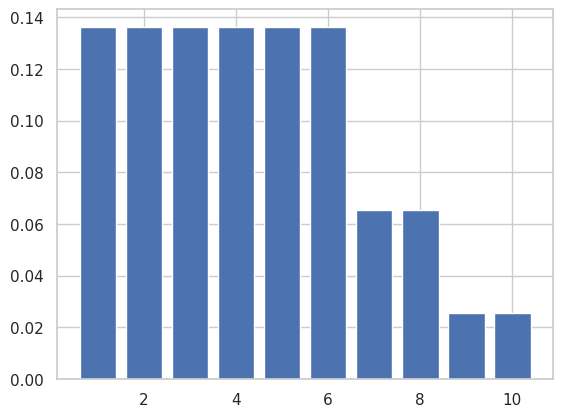

In [51]:
# 동일한 괴물이 다시 공격했다면, 이 때 6점의 피해를 입을 확률

ans = make_mixture(posterior, [make_die(sides) for sides in hypos])
ans.bar()

In [54]:
ans[6]

0.13634751773049647